# Merging

Files needed = (dogs.csv, steps.csv, ml-latest-small.zip)

We will often find ourselves with variables spread across different datasets and files. We *merge* datasets together by matching up the two datasets on one or more variables. For example, I might have GDP data by country from the Penn World Tables, and demographic data by country from the World Bank. We would merge these two datasets and match up the observations by country. 

Some of the most powerful analysis comes from combining data from different sources. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### The data

Let's return to the 'dogs.csv' file that tracks the snacks and walks for Buster and Su. Let's start with loading the data and trying a new option in `.read_csv()`. I pass `parse_dates` a list with columns that I want pandas to convert to datetimes. This saves us having to convert them ourselves. This option is available in `.read_excel()`, too.

In [2]:
dogs = pd.read_csv('dogs.csv', parse_dates=['time'])
dogs.dtypes

dog              object
var              object
time     datetime64[ns]
value             int64
dtype: object

In [3]:
dogs.sample(5)

,dog,var,time,value
19,Su,walks,2018-10-05,2
11,Su,snacks,2018-10-03,4
3,Buster,snacks,2018-10-02,3
13,Buster,walks,2018-10-05,3
21,Su,snacks,2018-10-04,3


The data are stacked. I move everything but the values into the index, and then unstack 'var'. 

In [4]:
dogs = dogs.set_index(['dog', 'time', 'var'])
dogs = dogs.unstack('var')
dogs

value      
var               snacks walks
dog    time                   
Buster 2018-10-01    4.0   2.0
       2018-10-02    3.0   2.0
       2018-10-03    4.0   NaN
       2018-10-04    5.0   2.0
       2018-10-05    4.0   3.0
       2018-10-06    3.0   1.0
       2018-10-07    2.0   3.0
Jax    2018-10-04    5.0   3.0
       2018-10-05    5.0   2.0
       2018-10-06    5.0   2.0
       2018-10-07    7.0   3.0
Su     2018-10-01    3.0   2.0
       2018-10-02    4.0   2.0
       2018-10-03    4.0   2.0
       2018-10-04    3.0   3.0
       2018-10-05    3.0   2.0
       2018-10-06    4.0   4.0
       2018-10-07    2.0   1.0

I do not like the nuisance index level 'value' so I remove it. I will reset the index, too. 

In [5]:
dogs = dogs.droplevel(0, axis=1)
dogs = dogs.reset_index()
dogs

var,dog,time,snacks,walks
0,Buster,2018-10-01,4.0,2.0
1,Buster,2018-10-02,3.0,2.0
2,Buster,2018-10-03,4.0,NaN
3,Buster,2018-10-04,5.0,2.0
4,Buster,2018-10-05,4.0,3.0
5,Buster,2018-10-06,3.0,1.0
6,Buster,2018-10-07,2.0,3.0
7,Jax,2018-10-04,5.0,3.0
8,Jax,2018-10-05,5.0,2.0
9,Jax,2018-10-06,5.0,2.0


### Steps data

I bought activity trackers for Buster and Su and their steps are recorded in an app. I downloaded their step data, and would like to add it to the dogs DataFrame. Let's load the steps file into a DataFrame and *merge* the two DataFrames. 

In [6]:
steps = pd.read_csv('steps.csv', parse_dates=['date'])
steps.sample(5)

,date,dog,steps
5,2018-10-06,Buster,377
19,2018-10-03,Jax,501
23,2018-10-07,Jax,549
7,2018-10-08,Buster,425
14,2018-10-07,Su,387


Steps is already in good shape. 

### Merge the two DataFrames into one DataFrame
We want to match the two DataFrames together according to the dog-date pairs. 
In database-ese, we refer to variables we are matching as **keys.** So, in our case, the keys are dog and date. 

We also need to tell pandas how to treat keys that are not present in both databases. The different types of 'join' (more database-ese) are
1. **inner**: keep the intersection of the keys
2. **left**: keep all the keys from the left DataFrame
3. **right**: keep all the keys from right DataFrame
4. **outer**: keep all the keys from both DataFrames

We specify the join type with the `how` parameter. The default is inner, but for sanity's sake, be explicit about your join.

Before we merge, let's review the two DataFrames.

In [7]:
print(dogs.head(2), '\n\n')
print(steps.head(2), '\n\n')
print('dogs has {0} rows and steps has {1} rows'.format(dogs.shape, steps.shape))

var     dog       time  snacks  walks
0    Buster 2018-10-01     4.0    2.0
1    Buster 2018-10-02     3.0    2.0 


        date     dog  steps
0 2018-10-01  Buster    503
1 2018-10-02  Buster    457 


dogs has (18, 4) rows and steps has (26, 3) rows


* Both DataFrames have a column named `dog` that holds the dog names
* The columns holding the date data have different names in the DataFrames
* The DataFrames have different numbers of observations

Let's see how `.merge()` handles these issues. 

### Inner merge

* Use `left` and `right` to label the DataFrames to merge
* Use `left_on` and `right_on` to identify the columns with keys. It's not a problem that one column is called 'dates' and the other 'time'

In [8]:
dogs_inner = pd.merge(left=dogs, right=steps, left_on=['dog', 'time'], right_on=['dog', 'date'], how='inner')
dogs_inner

,dog,time,snacks,walks,date,steps
0,Buster,2018-10-01,4.0,2.0,2018-10-01,503
1,Buster,2018-10-02,3.0,2.0,2018-10-02,457
2,Buster,2018-10-03,4.0,NaN,2018-10-03,299
3,Buster,2018-10-04,5.0,2.0,2018-10-04,550
4,Buster,2018-10-05,4.0,3.0,2018-10-05,476
5,Buster,2018-10-06,3.0,1.0,2018-10-06,377
6,Buster,2018-10-07,2.0,3.0,2018-10-07,405
7,Jax,2018-10-04,5.0,3.0,2018-10-04,465
8,Jax,2018-10-05,5.0,2.0,2018-10-05,510
9,Jax,2018-10-06,5.0,2.0,2018-10-06,563


The merged DataFrame has 17 rows&mdash;less than either of the DataFrames we started with. There are some rows that are only in `dogs` and some rows that are only in `steps`. Those rows are not included in the merged DataFrame when we use an inner merge. 

### Outer merge

An outer merge keeps all the keys&mdash;we do not lose any observations. I am adding the `indicator` to help us see how the two DataFrames compare. 

In [9]:
dogs_outer = pd.merge(left=dogs, right=steps, left_on=['dog', 'time'], right_on=['dog', 'date'], how='outer', indicator=True)
dogs_outer

,dog,time,snacks,walks,date,steps,_merge
0,Buster,2018-10-01,4.0,2.0,2018-10-01,503.0,both
1,Buster,2018-10-02,3.0,2.0,2018-10-02,457.0,both
2,Buster,2018-10-03,4.0,NaN,2018-10-03,299.0,both
3,Buster,2018-10-04,5.0,2.0,2018-10-04,550.0,both
4,Buster,2018-10-05,4.0,3.0,2018-10-05,476.0,both
5,Buster,2018-10-06,3.0,1.0,2018-10-06,377.0,both
6,Buster,2018-10-07,2.0,3.0,2018-10-07,405.0,both
7,Jax,2018-10-04,5.0,3.0,2018-10-04,465.0,both
8,Jax,2018-10-05,5.0,2.0,2018-10-05,510.0,both
9,Jax,2018-10-06,5.0,2.0,2018-10-06,563.0,both


The `_merge` variables helps us understand the inner merge, too. The observation Su 2018-10-03 is only in `dogs`, so it was dropped in the inner merge. The last nine rows are only in the `steps` data. Notice that pandas filled in NaN and NaT (not a time) where needed. Nice.

### Left merge

This merge keeps all the keys in the left DataFrame and only keeps the keys in the right DataFrame that have matches in the left DataFrame. 

In [10]:
dogs_left = pd.merge(left=dogs, right=steps, left_on=['dog', 'time'], right_on=['dog', 'date'], how='left', indicator=True)
dogs_left

,dog,time,snacks,walks,date,steps,_merge
0,Buster,2018-10-01,4.0,2.0,2018-10-01,503.0,both
1,Buster,2018-10-02,3.0,2.0,2018-10-02,457.0,both
2,Buster,2018-10-03,4.0,NaN,2018-10-03,299.0,both
3,Buster,2018-10-04,5.0,2.0,2018-10-04,550.0,both
4,Buster,2018-10-05,4.0,3.0,2018-10-05,476.0,both
5,Buster,2018-10-06,3.0,1.0,2018-10-06,377.0,both
6,Buster,2018-10-07,2.0,3.0,2018-10-07,405.0,both
7,Jax,2018-10-04,5.0,3.0,2018-10-04,465.0,both
8,Jax,2018-10-05,5.0,2.0,2018-10-05,510.0,both
9,Jax,2018-10-06,5.0,2.0,2018-10-06,563.0,both


The left merge keeps the observation Su 2018-10-03 even though it doesn't have a match in `steps`. 

The right merge works analogously. 

## Practice
Head over to [MovieLens](https://grouplens.org/datasets/movielens/) and download the ml-latest-small dataset. It will come as a zipped file. Put it in your user drive (and cwd) and unzip it. You will find 5 files. 


Each user ranks *movies* and can *tag* movies. Users have a `userId` and movies have a `movieId`.
* 'movies.csv' holds the description of movies. An observation is a movie.
* 'ratings.csv' holds user ratings of movies. An observation is a user-movie 
* 'tags.csv' holds the tags a user assigns to a movie. A observation is a user-movie. A user can add more than one tag per movie.


1. Load the 'movies.csv' and the 'ratings.csv' files as DataFrames
2. What size are the two DataFrames?


In [11]:
#1

movie = pd.read_csv("movies.csv")
print(movie.head(5))

movie.shape

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


(9742, 3)

In [12]:
rating = pd.read_csv("ratings.csv")
print(rating.head(5))

rating.shape

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


(100836, 4)

3. Merge the two files on the movieId. We want to keep all of the observations in ratings. Call your merged DataFrame 'movie_data'. Use the indicator option. 
4. What size is the resulting DataFrame?

In [24]:
#练习
#3 + 4
movie_data2 = pd.merge(left = movie, right = rating, on='movieId', how='right', indicator=True)
print(movie_data2.shape)
movie_data2.head(2)

(100836, 7)


,movieId,title,genres,userId,rating,timestamp,_merge
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,both
1,3,Grumpier Old Men (1995),Comedy|Romance,1,4.0,964981247,both


In [13]:
#3
movie_data = pd.merge(left=rating, right=movie, on='movieId', how='left', indicator=True)
print(movie_data.head())
print(movie_data.shape)

   userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0  964982931   Usual Suspects, The (1995)   

                                        genres _merge  
0  Adventure|Animation|Children|Comedy|Fantasy   both  
1                               Comedy|Romance   both  
2                        Action|Crime|Thriller   both  
3                             Mystery|Thriller   both  
4                       Crime|Mystery|Thriller   both  
(100836, 7)


In [14]:
movie_data.head(10)

,userId,movieId,rating,timestamp,title,genres,_merge
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,both
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,both
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,both
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,both
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,both
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller,both
6,1,101,5.0,964980868,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance,both
7,1,110,4.0,964982176,Braveheart (1995),Action|Drama|War,both
8,1,151,5.0,964984041,Rob Roy (1995),Action|Drama|Romance|War,both
9,1,157,5.0,964984100,Canadian Bacon (1995),Comedy|War,both


5. Use the `.value_counts()` method of DataFrame to tabulate the values in `_merge`. How many ratings are not matched to a movie?

In [25]:
#5
movie_data2.head(2)

total = movie_data2.value_counts(movie_data2['_merge'])
total

_merge
both          100836
left_only          0
right_only         0
dtype: int64

6. Create a histogram of the ratings. Use 10 bins. Use the density=True parameter to plot the density rather than the counts.

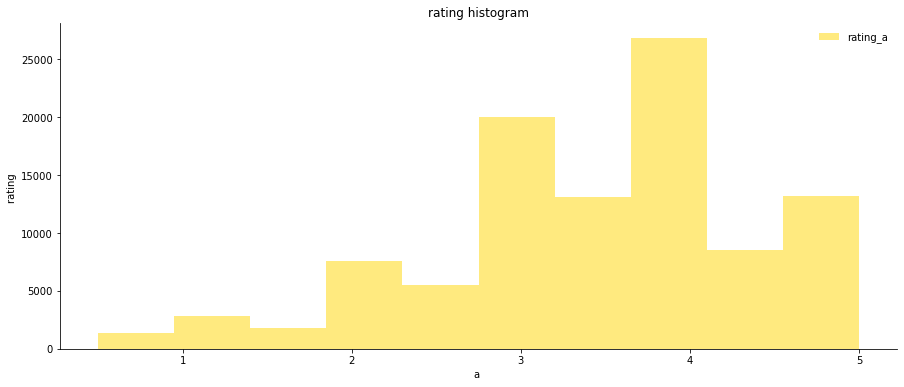

In [30]:
#6

fig, ax = plt.subplots(figsize=(15,6))


ax.hist(movie_data2['rating'], bins=10 ,color='gold', label = 'rating_a', alpha = 0.5) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False)

ax.set_title('rating histogram')
ax.set_xlabel('a ')
ax.set_ylabel('rating ')

plt.show()

7. Load the 'tags.csv' file
8. Merge it into your 'movie_data' DataFrame. What keys should you use? What type of join? Name this DataFrame `movie_data_2`. 

In [37]:
#7

tags = pd.read_csv('tags.csv')
print(tags.shape)
print(tags.head(4))
print(movie_data2.head(4))

(3683, 4)
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
   movieId                        title  \
0        1             Toy Story (1995)   
1        3      Grumpier Old Men (1995)   
2        6                  Heat (1995)   
3       47  Seven (a.k.a. Se7en) (1995)   

                                        genres  userId  rating  timestamp  \
0  Adventure|Animation|Children|Comedy|Fantasy       1     4.0  964982703   
1                               Comedy|Romance       1     4.0  964981247   
2                        Action|Crime|Thriller       1     4.0  964982224   
3                             Mystery|Thriller       1     5.0  964983815   

  _merge  
0   both  
1   both  
2   both  
3   both  


In [39]:
#8

movie_data2_2 = pd.merge(left = movie_data2, right = tags, on=['userId', 'movieId'], how='left')

movie_data2_2.head(4)

,movieId,title,genres,userId,rating,timestamp_x,_merge,tag,timestamp_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,both,NaN,NaN
1,3,Grumpier Old Men (1995),Comedy|Romance,1,4.0,964981247,both,NaN,NaN
2,6,Heat (1995),Action|Crime|Thriller,1,4.0,964982224,both,NaN,NaN
3,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1,5.0,964983815,both,NaN,NaN


9. Use `.value_count()` again to tabulate the `tag` column. Print out the top 5 tags. 

In [40]:
#9

tag_count = movie_data2_2.value_counts(movie_data2_2['tag'])

tag_count

tag
In Netflix queue    55
atmospheric         36
surreal             23
superhero           23
funny               23
                    ..
e-mail               1
earnest              1
easygoing            1
economics            1
"artsy"              1
Length: 1543, dtype: int64

I don't know what atmospheric means, so let's look at the tag, 'Disney'.

10. Compute the average rating for all movies and for movies tagged 'Disney'


In [48]:
#10
disney = movie_data2_2.loc[( movie_data2_2['tag'] == 'Disney'),'rating'].mean()
disney

3.5434782608695654

11. Let's see how the ratings of Disney movies compare to all movies. We will plot two histograms on the same axes.

    1. Plot the histogram of movies tagged 'Disney'. Use 10 bins. Make the plot blue.
    2. Plot the histogram of all movies (like you did for question 5). Use 10 bins. make the plot red.
    3. Add a legend
    4. Add the mean ratings for all movies and for superhero movies as text to the histogram

In [52]:
disn = movie_data2_2[( movie_data2_2['tag'] == 'Disney')]

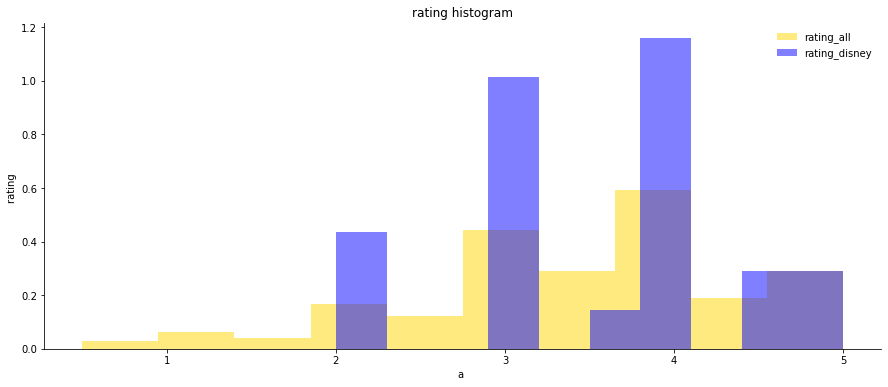

In [56]:
fig, ax = plt.subplots(figsize=(15,6))


ax.hist(movie_data2['rating'], bins=10 ,color='gold', density=True, label = 'rating_all', alpha = 0.5) 
ax.hist(disn['rating'], bins=10 ,color='blue', label = 'rating_disney',density=True, alpha = 0.5) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False)

ax.set_title('rating histogram')
ax.set_xlabel('a ')
ax.set_ylabel('rating ')

plt.show()